In [ ]:
libs <- c("here", "tidyverse",
          "rtracklayer", "biomaRt", "GenomicFeatures", "clusterProfiler", "SummarizedExperiment", "ensembldb", "tictoc")
invisible(suppressMessages(lapply(libs, library, character.only = TRUE)))

source(here('code', 'utils.R'))

theme_set(theme_bw(base_size = 20, base_family="Helvetica"))
theme_update(panel.grid.minor = element_blank(),
             panel.spacing = unit(1.5, "lines"),
             panel.border = element_blank(),
             axis.line = element_line(),
             plot.margin = margin(2, 2, 2, 2, unit = "lines"),
             panel.grid.major = element_blank(), 
             axis.ticks = element_line(),
             strip.background = element_blank(), 
             legend.title = element_blank())

library(org.Gg.eg.db)
library(org.Mm.eg.db)

In [3]:
#- Load in biomart

GRCg7b <- useEnsembl(biomart = "genes", dataset = 'ggallus_gene_ensembl')
GRCm39 <-  useEnsembl(biomart = "genes", dataset = "mmusculus_gene_ensembl")

# Description
Figure 1 looking at ortho relationship of genes between chicken & mouse. 

## Fig1A: Gene orthology 

In [223]:
head(bmOG)

Gene_stable_ID,Chicken_gene_stable_ID,Chicken_homology_type,"Chicken_orthology_confidence_[0_low,_1_high]",GOC_score
<chr>,<chr>,<chr>,<dbl>,<dbl>
ENSMUSG00000064341,ENSGALG00010000007,ortholog_one2one,1,50
ENSMUSG00000064345,ENSGALG00010000011,ortholog_one2one,1,75
ENSMUSG00000064351,ENSGALG00010000017,ortholog_one2one,1,100
ENSMUSG00000064354,ENSGALG00010000020,ortholog_one2one,1,100
ENSMUSG00000064357,ENSGALG00010000023,ortholog_one2one,1,100
ENSMUSG00000064358,ENSGALG00010000024,ortholog_one2one,1,100


In [4]:
## Ortho query from web server for mouse->chicken orthologous genes
bmOG <- suppressMessages(read_tsv(here("data", "references", "biomart_mouse-chicken_orthogenes.tsv")))
    colnames(bmOG) <- gsub(pattern = "\\s", "_", colnames(bmOG))
    colnames(bmOG)[-4][4] <- 'GOC_score'


## get chicken anno + for duplicated annotation, get the one with the highest GOC score
bmOG.ggal <- aggregate(GOC_score~Chicken_gene_stable_ID + Chicken_homology_type +Gene_stable_ID, bmOG, max) %>% 
    dplyr::select(ensembl_gene_id = Chicken_gene_stable_ID, 
                  homology_type = Chicken_homology_type, 
                  mmus_geneid = Gene_stable_ID) %>% 
    mutate(sp = 'ggal')



## query with biomaRt to get mouse homology type & score
bmOG.mmus <- getBM(attributes = c("mmusculus_homolog_ensembl_gene","mmusculus_homolog_orthology_type","mmusculus_homolog_goc_score"),
               filters = "ensembl_gene_id",
               values = bmOG$Chicken_gene_stable_ID, 
               mart = GRCg7b)

#any(duplicated(bmOG.mmus$mmusculus_homolog_ensembl_gene)) #TRUE  

## --> filter similarly
bmOG.mmus <- aggregate(mmusculus_homolog_goc_score~mmusculus_homolog_ensembl_gene + mmusculus_homolog_orthology_type, 
                       bmOG.mmus, max) %>% 
    dplyr::select(ensembl_gene_id = mmusculus_homolog_ensembl_gene, homology_type = mmusculus_homolog_orthology_type) %>% 
    mutate(sp = 'mmus')


## Get all annotated coding genes(CDG): chicken

bmCDG.ggal <- getBM(attributes = "ensembl_gene_id",
               filters = "biotype",
               values = "protein_coding", 
               mart = GRCg7b)
## Filter out ortho genes
bmCDG.ggal$homology_type <- 'unique'
bmCDG.ggal <- bmCDG.ggal[! bmCDG.ggal$ensembl_gene_id %in% bmOG.ggal$ensembl_gene_id, ]

## Get all annotated coding genes(CDG): mouse

bmCDG.mmus <- getBM(attributes = "ensembl_gene_id",
               filters = "biotype",
               values = "protein_coding", 
               mart = GRCm39)

## Filter out ortho genes
bmCDG.mmus$homology_type <- 'unique'
bmCDG.mmus <- bmCDG.mmus[! bmCDG.mmus$ensembl_gene_id %in% bmOG.mmus$ensembl_gene_id, ]

## Merge
bmCDG_anno <- rbind(dplyr::select(bmOG.ggal, -mmus_geneid), 
                    bmOG.mmus, 
                    mutate(bmCDG.ggal, sp = 'ggal'), 
                    mutate(bmCDG.mmus, sp = 'mmus'))


Batch submitting query [=======>-----------------------]  25% eta:  7s

Batch submitting query [===============>---------------]  50% eta:  4s

Batch submitting query [======================>--------]  75% eta:  2s
                                                                      



`summarise()` has grouped output by 'sp'. You can override using the `.groups` argument.


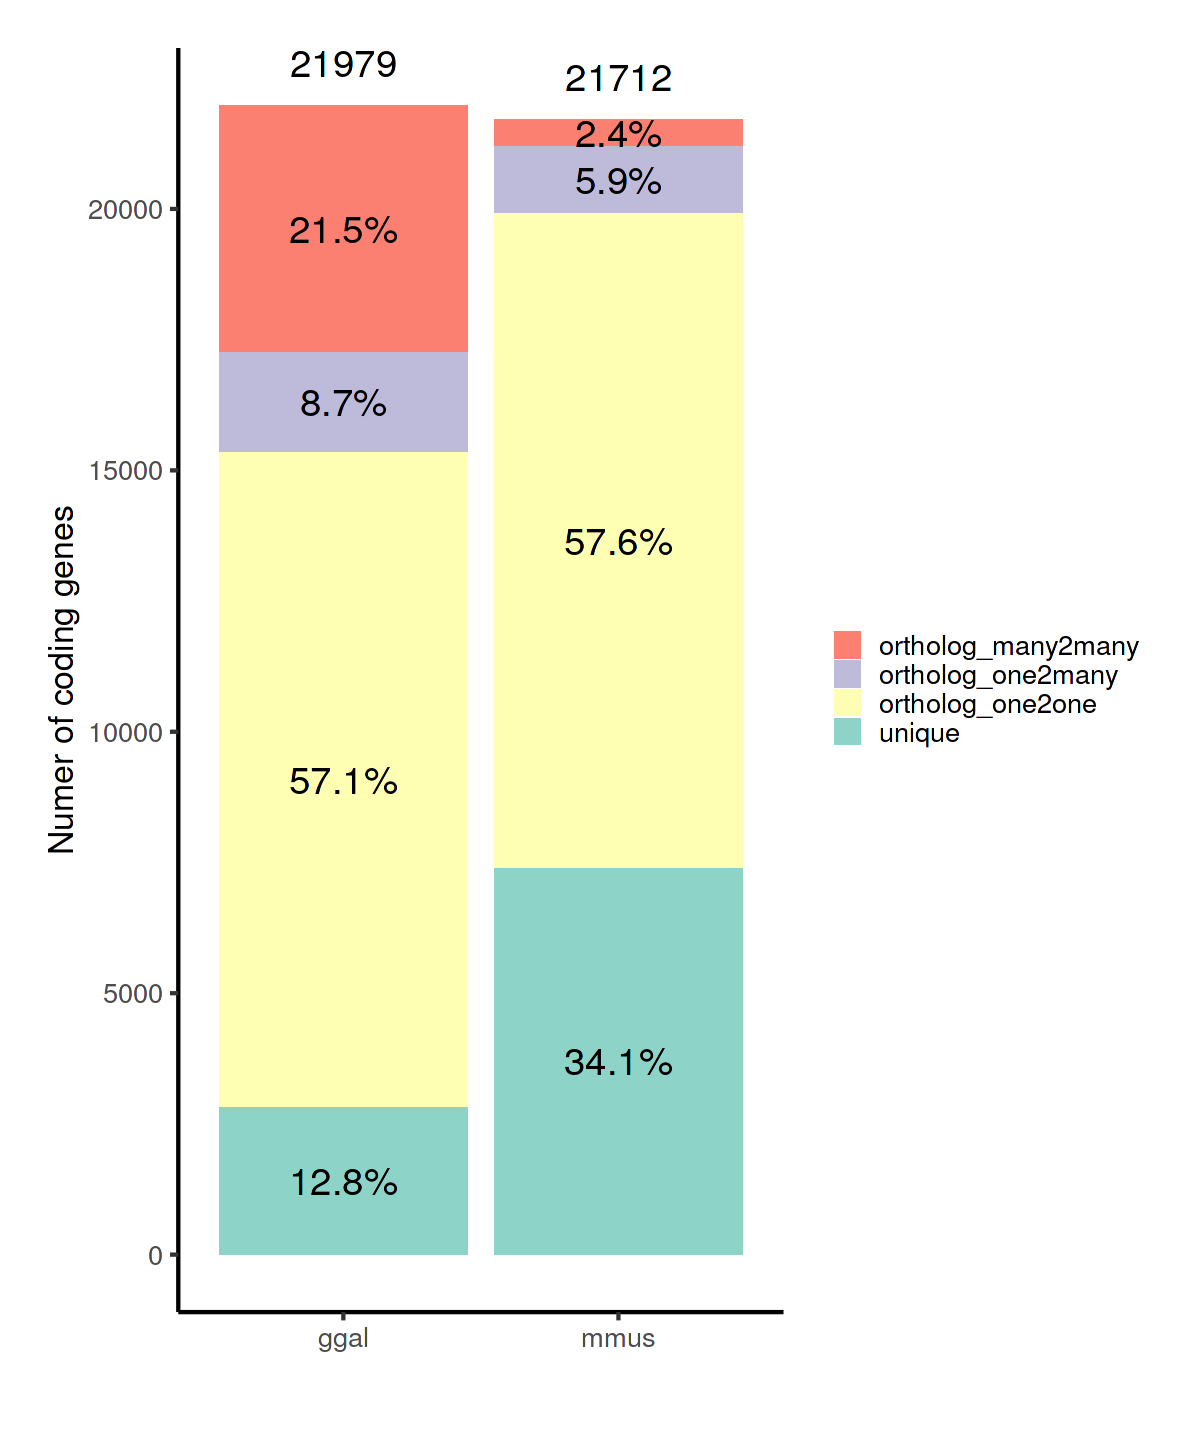

In [7]:
set_plot_dimensions(10,12)

fig1a <- bmCDG_anno %>%
group_by(sp, homology_type) %>%
summarise(count = n()) %>%
mutate(percentage = count / sum(count) * 100) %>% 
    ggplot(aes(x = sp, y = count, fill = homology_type)) +
    geom_bar(position = 'stack', stat = 'identity') +
    geom_text(aes(label = paste0(round(percentage, 1), "%")),
            stat = 'identity',
            position = position_stack(vjust = 0.5), size = 8) +
    scale_fill_brewer(palette = "Set3", direction = - 1) +
    geom_text(aes(label = after_stat(y), group = sp), 
    stat = 'summary', fun = sum, vjust = -1, size = 8) +
    labs (x='', y = 'Numer of coding genes')

fig1a

ggsave(here('code', '_figures', 'fig1a_ortho_genes_mmus_ggal.pdf'), width = 10, height = 12)


## Fig1B: OG & Unique genes GO annotations

NOTE: Incorporate expression data before GO would make more sense 

1. Load in TPM counts
2. For GO over-representation: gene universe = TPM >=1 (n = 13030)
3. For GSE-GO: Sort OG & unique genes by median TPM across 4 libs

_Integrating our expression datasets with described orthology, we could have an overview of the functionalities of expressed 1-1 OGs at equivalent stages of heart development by GO analysis_

## Load in TPM gene counts from STAR alignment 


In [8]:
load(here('data', 'rna', 'heart_TPM_unstranded_counts_star.RData'))

### Functions

In [9]:
getExpressedGenes <- function(count_mat, minTPM=1){
    keep <- (count_mat[, 1] >= minTPM & count_mat[, 2] >= minTPM) | (count_mat[, 3] >= minTPM & count_mat[, 4] >= minTPM)
    return(row.names(count_mat[keep, ] ))
}

mapIds.wrapper <- function(mart,genes,get.Attributes='entrezgene_id', df.out = FALSE){
    ##wrapper to convert ensemble IDs
    mapped <- getBM(attributes = get.Attributes, 
                    filters = "ensembl_gene_id", 
                    values = genes, 
                    mart = mart)
    if (!df.out) {
        return(mapped[,get.Attributes])
    } else { 
        return(mapped) 
           }
}

engo.wrapper <- function(genes, gene.universe, 
                         OrgDb, max.pval=0.05, ont='BP', maxGS=100, minGS=5){
    engo <- enrichGO(gene = genes, 
                     OrgDb = OrgDb, 
                     universe = gene.universe,
                     pAdjustMethod = "BH",
                     pvalueCutoff  = max.pval,
                     minGSSize = minGS,
                     maxGSSize = maxGS, 
                     ont = 'BP', 
                     readable = TRUE)
    out <- data.frame(engo)
    if (nrow(out)!= 0) {
        out <- out %>% group_by(geneID) %>% summarise_all(min) %>% 
        arrange(p.adjust) %>% 
        mutate(padj = -log10(p.adjust))
        return(out)
    }
}

In [10]:
## GO results are often redundant, here if a GO share more than 80% of genes, keep the term with highest padj

calculateSharedPercentage <- function(geneID1, geneID2) {
  genes1 <- strsplit(geneID1, "/")[[1]]
  genes2 <- strsplit(geneID2, "/")[[1]]
  sharedGenes <- intersect(genes1, genes2)
  percentage <- length(sharedGenes) / max(length(genes1), length(genes2))
  return(percentage)
}


filterGOResults <- function(go_res, top_nrow=50, max_overlap = 0.8){
    ## GO results already sorted by padj
    go.df <- head(go_res, top_nrow)
    
    # calculate shared identity 
    sharedPercentages <- outer(go.df$geneID, go.df$geneID, 
                               Vectorize(calculateSharedPercentage))
    
    matchingIndices <- lapply(seq_len(nrow(go.df)), function(i) {
                        matches <- which(sharedPercentages[i, ] >= max_overlap)
                        matches[matches != i]
                        })

    keep_idx <- c()
    matched <- c()
    for (i in seq_along(matchingIndices)){
    if (length(matchingIndices[[i]]) == 0) {
        keep_idx <- c(keep_idx, i)
    } else {
        matched <- c(matched, matchingIndices[[i]])
        if (i %in% matched) next
        keep_idx <- c(keep_idx, i)
    }
    }
    
    return(go.df[keep_idx, ])
}


### GO analysis & plot

- For ortho genes, take mouse annotations. For unique, take species-specific anno


In [11]:
## Get all coding genes & filter by expression

bg_genes.mmus <- intersect(bmCDG_anno[bmCDG_anno$sp == 'mmus', 'ensembl_gene_id'], 
                           getExpressedGenes(count_mat = assay(se.mmus_tpm)))

bg_genes.ggal <- intersect(bmCDG_anno[bmCDG_anno$sp == 'ggal', 'ensembl_gene_id'], 
                           getExpressedGenes(count_mat = assay(se.ggal_tpm)))

In [12]:
length(bg_genes.mmus)
length(bg_genes.ggal)

[1] 13004

[1] 12684

In [13]:
## Unique genes ##
uniq_genes.ggal <- intersect(bmCDG_anno[bmCDG_anno$sp == 'ggal' & bmCDG_anno$homology_type == 'unique', 'ensembl_gene_id'], 
                           getExpressedGenes(count_mat = assay(se.ggal_tpm)))
uniq_genes.mmus <- intersect(bmCDG_anno[bmCDG_anno$sp == 'mmus' & bmCDG_anno$homology_type == 'unique', 'ensembl_gene_id'], 
                           getExpressedGenes(count_mat = assay(se.mmus_tpm)))

In [14]:
#- 1:1 OGs ##
og_genes.mmus <- intersect(bmOG.mmus[bmOG.mmus$homology_type == 'ortholog_one2one', 'ensembl_gene_id'], 
                           getExpressedGenes(count_mat = assay(se.mmus_tpm)))

##- intersect expressed OGs by first getting chicken TPMs
bmOG_expressed.ggal <- aggregate(GOC_score~Chicken_gene_stable_ID+Chicken_homology_type+Gene_stable_ID, 
                                 bmOG, max) %>% 
                       dplyr::filter(Chicken_gene_stable_ID %in% getExpressedGenes(count_mat = assay(se.ggal_tpm))) %>% 
                       dplyr::filter(Chicken_homology_type == 'ortholog_one2one')

##- get expressed OGs in both
og_genes.both <- intersect(og_genes.mmus, bmOG_expressed.ggal$Gene_stable_ID)

#length(og_genes.both) #9479
#length(og_genes.mmus) #10012
#length(uniq_genes.mmus) #2408
#length(uniq_genes.ggal) #1303

for paper text, get proportion 

In [15]:
length(og_genes.mmus)/length(bg_genes.mmus)
length(bmOG_expressed.ggal$Gene_stable_ID)/length(bg_genes.ggal)

[1] 0.7688404

[1] 0.8421634

- reduce the size of testing gene sets to allow for more specific processes, i.e. heart development vs more global ones like mRNA processing

In [16]:
## Run enGO 

engo_OG_exp <- engo.wrapper(genes = mapIds.wrapper(genes = og_genes.both, 
                                               mart = GRCm39),
                            gene.universe = mapIds.wrapper(genes = bg_genes.mmus, 
                                                       mart = GRCm39),
                            OrgDb = org.Mm.eg.db,
                            max.pval = 0.01)

engo_uniq_exp.mmus <- engo.wrapper(genes = mapIds.wrapper(genes = uniq_genes.mmus, 
                                               mart = GRCm39),
                            gene.universe = mapIds.wrapper(genes = bg_genes.mmus, 
                                                       mart = GRCm39),
                            OrgDb = org.Mm.eg.db,
                            max.pval = 0.01)

## No enriched GO, maybe just no annotation
engo_uniq_exp.ggal <- engo.wrapper(genes = mapIds.wrapper(genes = uniq_genes.ggal, 
                                               mart = GRCg7b),
                            gene.universe = mapIds.wrapper(genes = bg_genes.ggal, 
                                                       mart = GRCg7b),
                            OrgDb = org.Gg.eg.db,
                            max.pval = 0.01)


Batch submitting query [===============>---------------]  50% eta: 22s
                                                                      


Batch submitting query [=========>---------------------]  33% eta:  5s

Batch submitting query [====================>----------]  67% eta:  2s
                                                                      

`universe` is not in character and will be ignored...

`universe` is not in character and will be ignored...


Batch submitting query [=========>---------------------]  33% eta: 20s

Batch submitting query [====================>----------]  67% eta:  6s
                                                                      

`universe` is not in character and will be ignored...



In [19]:
## Filter GO results
tic()

engo_all <- rbind(mutate(filterGOResults(go_res = engo_OG_exp), grp = 'OGs'), 
                 mutate(head(filterGOResults(go_res = engo_uniq_exp.mmus, top_nrow = 18), 5), 
                        grp = 'Unique_mmus'))

toc()

0.307 sec elapsed


In [20]:
library(viridis)
## Manual filtering of relevant GO terms

goterms <- c('cardiac septum morphogenesis', 
             'regulation of stress fiber assembly',
             'outflow tract morphogenesis', 
             'actin-mediated cell contraction', 
             'morphogenesis of a polarized epithelium', 
             engo_all[engo_all$grp == 'Unique_mmus', ]$Description)




engo_plt <-  engo_all %>% dplyr::filter(Description %in% goterms) 
engo_plt$Description <- factor(engo_plt$Description, levels = goterms)

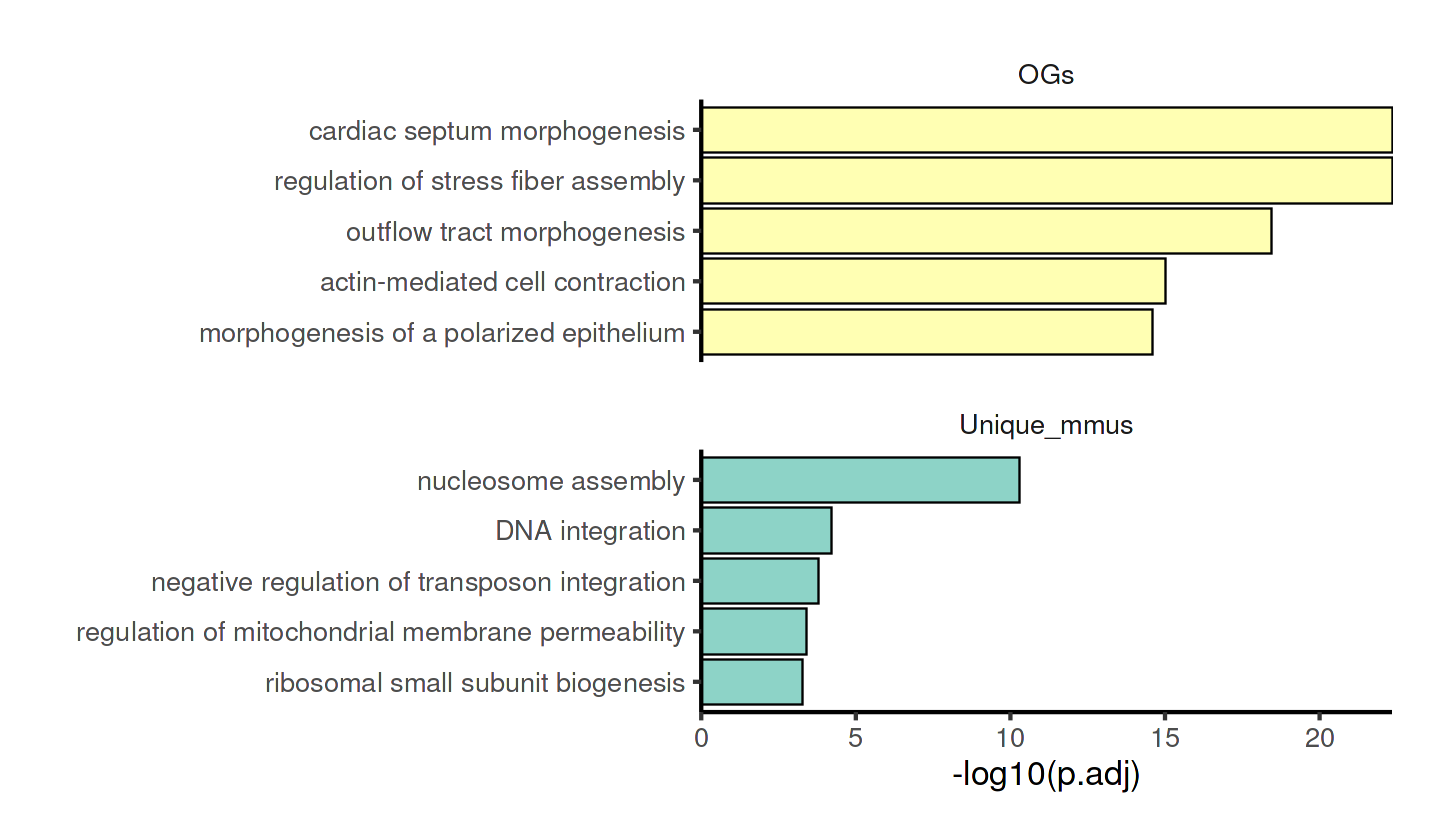

In [21]:
w=12
h=7
set_plot_dimensions(w, h)


fig1b <- engo_plt %>% 
    ggplot(aes(x=fct_rev(Description), y = padj, fill = grp)) +
    geom_col(color = 'black')+ 
    coord_flip() +
    scale_y_continuous(expand=c(0,0)) +
    facet_wrap(vars(grp), scales= "free_y", nrow = 2) +
    labs(x='', y='-log10(p.adj)') +
    scale_fill_brewer(palette = "Set3", direction = - 1) +
    theme(legend.position = 'none')


fig1b

ggsave(here('code', '_figures', 'fig1b_ortho_genes_enrichGO.pdf'), width = w, height = h)

## Gene Expression

plot Heatmap of TPM counts in both stages & species

In [ ]:
library(BiocParallel)
library(ComplexHeatmap)

In [256]:
#-- change all OG row names to mmus gene name
idx.gg <- match(row.names(assay(se.ggal_tpm)), bmOG.ggal$ensembl_gene_id)

## make new matrix for only OG

mat_tpm.OG <- assay(se.ggal_tpm)[-which(is.na(idx.gg)), ]
row.names(mat_tpm.OG) <-  bmOG.ggal$mmus_geneid[idx.gg[!is.na(idx.gg)] ]

#dim(assay(se.ggal_tpm)) #301084 4
#dim(mat_tpm.OG) #142014 4

#-- merge with mouse TPM

mat_tpm.OG <- cbind(mat_tpm.OG, 
                   assay(se.mmus_tpm)[row.names(mat_tpm.OG), ])

#dim(mat_tpm.OG) #142014 8

[1] 14201     8

In [262]:
## get mean TPM from 2 replicates

mat_tpm.OG_merged <- cbind(rowMeans(mat_tpm.OG[, c(1,2)]), 
                          rowMeans(mat_tpm.OG[, c(3,4)]), 
                          rowMeans(mat_tpm.OG[, c(5,6)]), 
                          rowMeans(mat_tpm.OG[, c(7,8)]))

colnames(mat_tpm.OG_merged) <- unique(str_extract(colnames(mat_tpm.OG), pattern = 'HH22|HH24|E105|E115'))

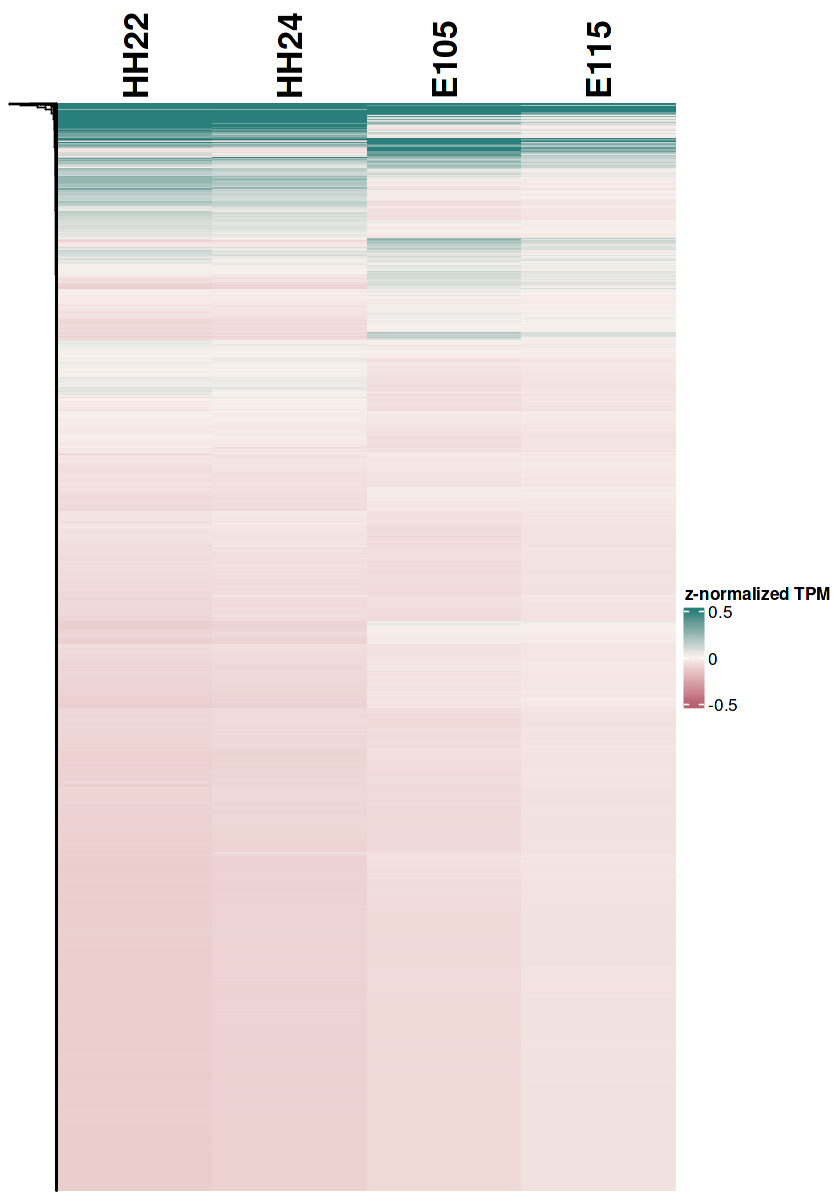

In [274]:
set_plot_dimensions(7, 10)

col_fun <- circlize::colorRamp2(c(-0.5, 0, 0.5), c('#B86272','#f8f1ed','#287F7C'))

OG_hm <- Heatmap(scale(mat_tpm.OG_merged), 
        cluster_columns  = FALSE, 
        name = 'z-normalized TPM',
        column_names_side = 'top',
        column_names_gp = gpar(fontsize = 20, fontface ='bold'),
        show_row_names = FALSE, 
        col = col_fun)

draw(OG_hm)